In [10]:
!pip -q install kaggle

from google.colab import files
import pathlib, os

print("Lütfen bilgisayarından 'kaggle.json' dosyasını seç (Kaggle > Account > Create New API Token).")
uploaded = files.upload()  # ⬅️ popup açılır; kaggle.json'u seç

home = pathlib.Path("/root/.kaggle")
home.mkdir(parents=True, exist_ok=True)

if "kaggle.json" not in uploaded:
    raise FileNotFoundError("kaggle.json yüklenmedi.")

with open(home / "kaggle.json", "wb") as f:
    f.write(uploaded["kaggle.json"])

!chmod 600 /root/.kaggle/kaggle.json
print("Kaggle API hazır ✅  (/root/.kaggle/kaggle.json)")

# hızlı kontrol
!kaggle -v
!ls -l /root/.kaggle

Lütfen bilgisayarından 'kaggle.json' dosyasını seç (Kaggle > Account > Create New API Token).


Saving kaggle.json to kaggle.json
Kaggle API hazır ✅  (/root/.kaggle/kaggle.json)
Kaggle API 1.7.4.5
total 4
-rw------- 1 root root 68 Sep 26 13:59 kaggle.json


In [11]:
!kaggle datasets download -d puneet6060/intel-image-classification -p /content
!unzip -qo /content/intel-image-classification.zip -d /content/intel

import os
BASE_DIR = "/content/intel/seg_train/seg_train"
TEST_DIR = "/content/intel/seg_test/seg_test"
print("Eğitim klasörü:", os.path.exists(BASE_DIR), BASE_DIR)
print("Test klasörü  :", os.path.exists(TEST_DIR), TEST_DIR)

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 83% 286M/346M [00:06<00:01, 39.6MB/s]
100% 346M/346M [00:06<00:00, 55.8MB/s]
Eğitim klasörü: True /content/intel/seg_train/seg_train
Test klasörü  : True /content/intel/seg_test/seg_test


In [12]:
import tensorflow as tf, numpy as np, random, os

IMG_SIZE   = 224
BATCH_SIZE = 32
SEED       = 42
tf.random.set_seed(SEED); np.random.seed(SEED); random.seed(SEED)

BASE_DIR = "/content/intel/seg_train/seg_train"
TEST_DIR = "/content/intel/seg_test/seg_test"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    BASE_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=0.15,
    subset="training",
    seed=SEED,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    BASE_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=0.15,
    subset="validation",
    seed=SEED,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print("Sınıflar:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

Found 14034 files belonging to 6 classes.
Using 11929 files for training.
Found 14034 files belonging to 6 classes.
Using 2105 files for validation.
Found 3000 files belonging to 6 classes.
Sınıflar: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [13]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_pre

IMG_SIZE = 224

data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="aug")

def build_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=len(class_names), train_base=False):
    inputs = layers.Input(shape=input_shape)
    x = data_aug(inputs)
    x = mobilenet_pre(x)                                # MobileNetV2 preprocess
    base = MobileNetV2(include_top=False, weights="imagenet", input_tensor=x)
    base.trainable = train_base                         # Stage-1: False (freeze)
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inputs, outputs, name="MobileNetV2_Intel")

model = build_model(train_base=False)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])
model.summary()

/tmp/ipython-input-3322829124.py:17: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(include_top=False, weights="imagenet", input_tensor=x)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "MobileNetV2_Intel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aug (Sequential)    │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide         │ (None, 224, 224,  │          0 │ aug[0][0]         │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 224, 224,  │          0 │ true_divide[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ subtract[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

cb1 = [
    EarlyStopping(patience=3, restore_best_weights=True, monitor="val_accuracy"),
    ReduceLROnPlateau(patience=2, factor=0.5, monitor="val_loss"),
    ModelCheckpoint("/content/mnv2_stage1_best.keras", save_best_only=True, monitor="val_accuracy"),
]

history1 = model.fit(train_ds, validation_data=val_ds, epochs=8, callbacks=cb1)

Epoch 1/8
373/373 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - accuracy: 0.7128 - loss: 0.7520 - val_accuracy: 0.8907 - val_loss: 0.2949 - learning_rate: 0.0010
Epoch 2/8
373/373 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8653 - loss: 0.3578 - val_accuracy: 0.8998 - val_loss: 0.2702 - learning_rate: 0.0010
Epoch 3/8
373/373 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8800 - loss: 0.3317 - val_accuracy: 0.8964 - val_loss: 0.2717 - learning_rate: 0.0010
Epoch 4/8
373/373 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8826 - loss: 0.3151 - val_accuracy: 0.9093 - val_loss: 0.2575 - learning_rate: 0.0010
Epoch 5/8
373/373 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8810 - loss: 0.3198 - val_accuracy: 0.9050 - val_loss: 0.2579 - learning_rate: 0.0010
Epoch 6/8
373/373 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8864 - loss: 0.3139 - val_accuracy: 0.9017 - val_loss: 0.2635 - learning_rate: 0.0010
Epoch 7/8
373/373 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8928 - loss: 0.

In [15]:
# son ~30 katmanı eğitime aç
unfreeze_from = len(model.layers) - 30
for i, lyr in enumerate(model.layers):
    if i >= unfreeze_from:
        lyr.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),   # küçük LR
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

cb2 = [
    EarlyStopping(patience=3, restore_best_weights=True, monitor="val_accuracy"),
    ReduceLROnPlateau(patience=2, factor=0.5, monitor="val_loss"),
    ModelCheckpoint("/content/mnv2_stage2_best.keras", save_best_only=True, monitor="val_accuracy"),
]

history2 = model.fit(train_ds, validation_data=val_ds, epochs=8, callbacks=cb2)

Epoch 1/8
373/373 ━━━━━━━━━━━━━━━━━━━━ 42s 86ms/step - accuracy: 0.8061 - loss: 0.5418 - val_accuracy: 0.9083 - val_loss: 0.2601 - learning_rate: 1.0000e-05
Epoch 2/8
373/373 ━━━━━━━━━━━━━━━━━━━━ 30s 79ms/step - accuracy: 0.8627 - loss: 0.3766 - val_accuracy: 0.9159 - val_loss: 0.2519 - learning_rate: 1.0000e-05
Epoch 3/8
373/373 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.8779 - loss: 0.3433 - val_accuracy: 0.9178 - val_loss: 0.2513 - learning_rate: 1.0000e-05
Epoch 4/8
373/373 ━━━━━━━━━━━━━━━━━━━━ 30s 79ms/step - accuracy: 0.8818 - loss: 0.3101 - val_accuracy: 0.9211 - val_loss: 0.2479 - learning_rate: 1.0000e-05
Epoch 5/8
373/373 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.8906 - loss: 0.2929 - val_accuracy: 0.9216 - val_loss: 0.2427 - learning_rate: 1.0000e-05
Epoch 6/8
373/373 ━━━━━━━━━━━━━━━━━━━━ 30s 79ms/step - accuracy: 0.8943 - loss: 0.2827 - val_accuracy: 0.9230 - val_loss: 0.2372 - learning_rate: 1.0000e-05
Epoch 7/8
373/373 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - acc

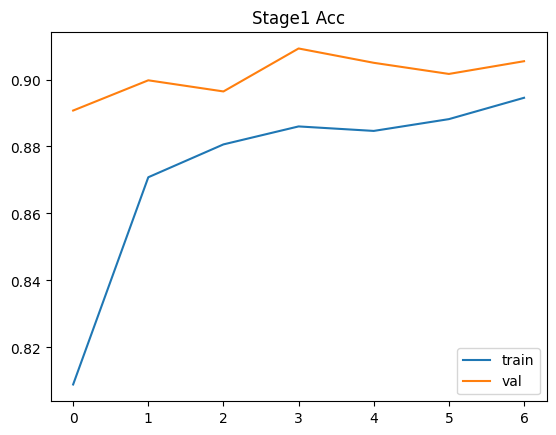

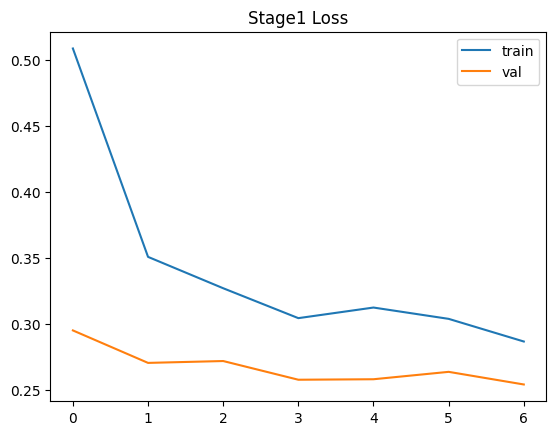

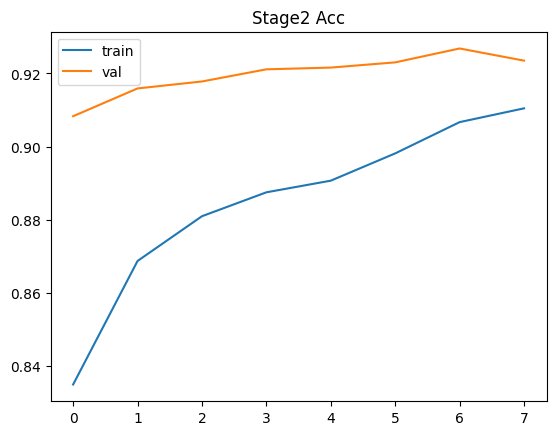

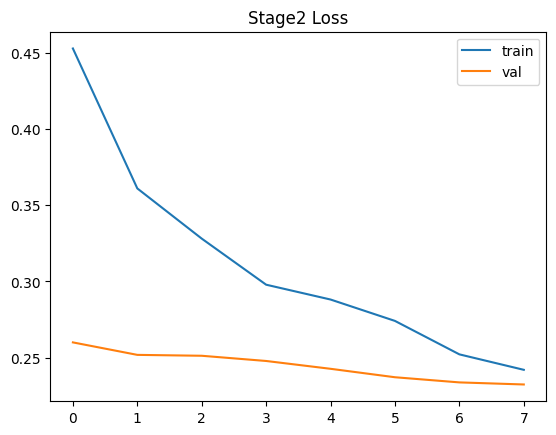

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def plot_history(h, title=""):
    plt.figure(); plt.plot(h.history["accuracy"], label="train"); plt.plot(h.history["val_accuracy"], label="val")
    plt.title(title+" Acc"); plt.legend(); plt.show()
    plt.figure(); plt.plot(h.history["loss"], label="train"); plt.plot(h.history["val_loss"], label="val")
    plt.title(title+" Loss"); plt.legend(); plt.show()

plot_history(history1, "Stage1")
plot_history(history2, "Stage2")

test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"TEST acc={test_acc:.4f} loss={test_loss:.4f}")

y_true, y_pred = [], []
for xb, yb in test_ds:
    p = model.predict(xb, verbose=0)
    y_pred.extend(np.argmax(p, axis=1)); y_true.extend(yb.numpy())

print(classification_report(y_true, y_pred, target_names=class_names))
cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm); plt.title("Confusion Matrix"); plt.colorbar(); plt.show()

In [2]:

import os, json, tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_pre

# 1) Sınıf isimlerini dizinden toparla (eğitim datasetini kurmadıysan bile çalışır)
TRAIN_ROOT = "/content/intel/seg_train/seg_train"
class_names = sorted([d for d in os.listdir(TRAIN_ROOT) if os.path.isdir(os.path.join(TRAIN_ROOT, d))])
print("class_names:", class_names)

# 2) Önce stage2-best varsa onu tam model olarak yüklemeyi dene
model = None
ckpts_try = ["/content/mnv2_stage2_best.keras", "/content/mnv2_stage1_best.keras"]
for ck in ckpts_try:
    if os.path.exists(ck):
        try:
            model = tf.keras.models.load_model(ck)   # Tüm modeli yükler
            print(f"Loaded FULL model from: {ck}")
            break
        except Exception as e:
            print(f"Full load failed for {ck} -> {e}")

# 3) Tam model yüklenemediyse: mimariyi kurup ağırlıkları yükle
if model is None:
    def build_model(input_shape=(224,224,3), num_classes=len(class_names)):
        inputs = layers.Input(shape=input_shape)
        x = mobilenet_pre(inputs)
        base = MobileNetV2(include_top=False, weights=None, input_tensor=x)  # weightleri dosyadan alacağız
        x = layers.GlobalAveragePooling2D()(base.output)
        x = layers.Dropout(0.3)(x)
        outputs = layers.Dense(num_classes, activation="softmax")(x)
        return models.Model(inputs, outputs, name="MobileNetV2_Intel")
    model = build_model()
    # Sırayla deneyelim
    loaded = False
    for ck in ckpts_try:
        if os.path.exists(ck):
            try:
                model.load_weights(ck)
                print(f"Loaded WEIGHTS from: {ck}")
                loaded = True
                break
            except Exception as e:
                print(f"Weight load failed for {ck} -> {e}")
    assert loaded, "Hiçbir checkpoint bulunamadı: mnv2_stage2_best.keras / mnv2_stage1_best.keras"

# 4) Final dosyalarını kaydet
model.save("/content/mnv2_intel_final.keras")
with open("/content/class_names.json","w") as f:
    json.dump(class_names, f)

print("✓ Kaydedildi -> /content/mnv2_intel_final.keras ve /content/class_names.json")

class_names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Loaded FULL model from: /content/mnv2_stage2_best.keras
✓ Kaydedildi -> /content/mnv2_intel_final.keras ve /content/class_names.json
